# Predicting House Prices

**Sales prices prediction using an artificial neural network in Keras**

**Supervised Learning. Regression**

Source: Ames Housing dataset ([Kaggle website](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)).  

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ds_boost
from tensorflow import keras

log = ds_boost.logger.init(level="DEBUG", save_log=False)

ds_boost.set_parent_execution_path()
ds_boost.info_system()
sns.set_palette("GnBu_d")
# ds_boost.reproducible(seed=0) # Setup reproducible results from run to run using Keras

%matplotlib inline
%load_ext autoreload
%autoreload 2

23:03:12 - DEBUG 	 Path changed to /home/angel/DRIVE/0_repos/data-science-keras
23:03:12 - DEBUG 	 HARDWARE:
23:03:13 - DEBUG 	 CPU:	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
23:03:13 - DEBUG 	 RAM:	15 GB
23:03:13 - DEBUG 	 -- No GPU  --
23:03:13 - DEBUG 	 OS:	Linux-5.15.0-57-generic-x86_64-with-glibc2.35
23:03:13 - DEBUG 	 ENV:	/home/angel/miniconda3/envs/ds-keras
23:03:13 - DEBUG 	 PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
23:03:13 - DEBUG 	 tensorflow                   2.11.0
23:03:13 - DEBUG 	 pandas                        1.5.2
23:03:13 - DEBUG 	 numpy                        1.24.1
23:03:13 - DEBUG 	 EXECUTION PATH: /home/angel/DRIVE/0_repos/data-science-keras
23:03:13 - DEBUG 	 EXECUTION DATE: Mon Jan 16 23:03:13 2023


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = "data/house_prices_data.csv"
target = ["SalePrice"]

df_original = pd.read_csv(data_path)

### Explore the data

In [3]:
ds_boost.info_data(df_original, target)

23:03:13 - DEBUG 	 Samples: 	1460.  	 Features: 	80
23:03:13 - DEBUG 	 Target: 	SalePrice


In [4]:
df_original.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### Missing values

['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

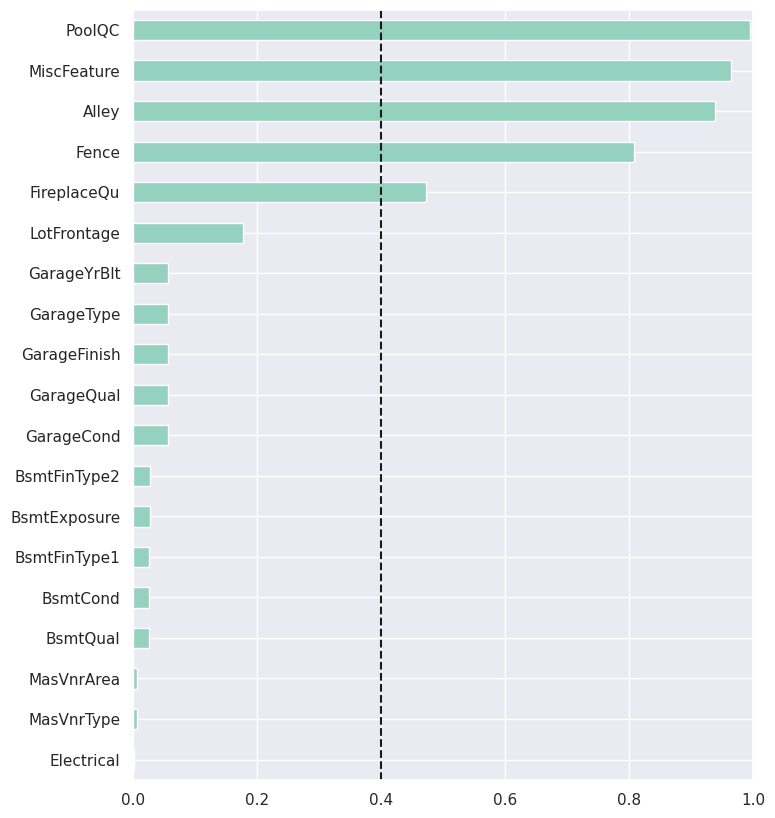

In [5]:
high_missing = ds_boost.missing(df_original, limit=0.4, plot=True)
high_missing

### Transform the data

#### Remove irrelevant features

In [6]:
df = df_original.copy()  # modified dataset

# remove non-significant and high-missing features
droplist = ["Id"] + high_missing

assert not set(droplist).intersection(set(target)), "Targets cannot be dropped"

df.drop(droplist, axis="columns", inplace=True)

#### Classify variables

Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [7]:
numerical = list(df.select_dtypes(include=[np.number]))

df = ds_boost.sort_columns_by_type(df, target, numerical=numerical)

ds_boost.get_types(df)

23:03:14 - DEBUG 	 36 numerical features: 	 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
23:03:14 - DEBUG 	 38 categorical features: 	 ['GarageType', 'LandContour', 'Neighborhood', 'Heating', 'CentralAir', 'Foundation', 'BsmtCond', 'KitchenQual', 'BsmtFinType2', 'GarageQual', 'BldgType', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'Street', 'Condition1', 'Exterior2nd', 'SaleType', 'ExterQual', 'PavedDrive', 'Electrical', 'SaleCondition', 'MSZoning', 'HeatingQC', 'Exterior1st', 'MasVnrType', 'Utilities', 'ExterCond', 'GarageFinish', 'LotSh

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,LotShape,LandSlope,Functional,RoofMatl,HouseStyle,LotConfig,RoofStyle,GarageCond,Condition2,SalePrice
Type,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,...,category,category,category,category,category,category,category,category,category,float32


#### Remove low frequency values from categorical features

In [8]:
df, dict_categories = ds_boost.remove_categories(df, target, ratio=0.01)

23:03:15 - DEBUG 	 Removing 2 categories from feature GarageType
23:03:15 - DEBUG 	 Removing 3 categories from feature Neighborhood
23:03:15 - DEBUG 	 Removing 4 categories from feature Heating
23:03:15 - DEBUG 	 Removing 2 categories from feature Foundation
23:03:15 - DEBUG 	 Removing 1 categories from feature BsmtCond
23:03:15 - DEBUG 	 Removing 1 categories from feature BsmtFinType2
23:03:15 - DEBUG 	 Removing 3 categories from feature GarageQual
23:03:15 - DEBUG 	 Removing 1 categories from feature Street
23:03:15 - DEBUG 	 Removing 4 categories from feature Condition1
23:03:15 - DEBUG 	 Removing 6 categories from feature Exterior2nd
23:03:15 - DEBUG 	 Removing 6 categories from feature SaleType
23:03:15 - DEBUG 	 Removing 1 categories from feature ExterQual
23:03:15 - DEBUG 	 Removing 2 categories from feature Electrical
23:03:15 - DEBUG 	 Removing 2 categories from feature SaleCondition
23:03:15 - DEBUG 	 Removing 1 categories from feature MSZoning
23:03:15 - DEBUG 	 Removing 1 c

#### Fill missing values
Numerical -> median, categorical -> mode

In [9]:
df = ds_boost.fill_simple(df, target)

### Visualize the data

#### Target vs some significant features

(34900.0, 600000.0)

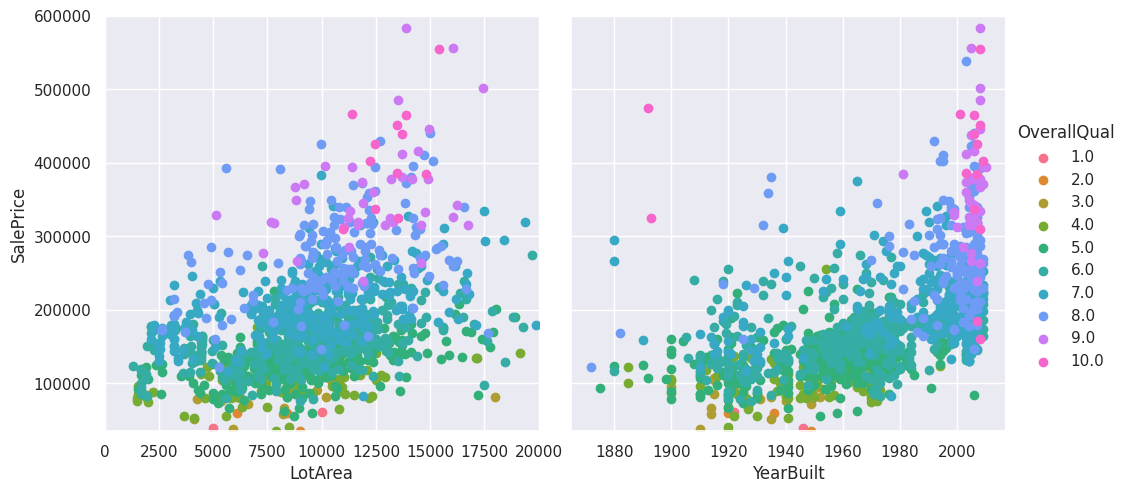

In [10]:
g = sns.PairGrid(df, y_vars=["SalePrice"], x_vars=["LotArea", "YearBuilt"], height=5, hue="OverallQual")
g.map(plt.scatter).add_legend()
g.axes[0, 0].set_xlim(0, 20000)
plt.ylim(df["SalePrice"].min(), 600000)

Lower sale prices are usually found in very low overall quality houses, with less dependency on its size and the year of construction. These three features alone are insufficient to make a good price prediction.

#### Categorical features

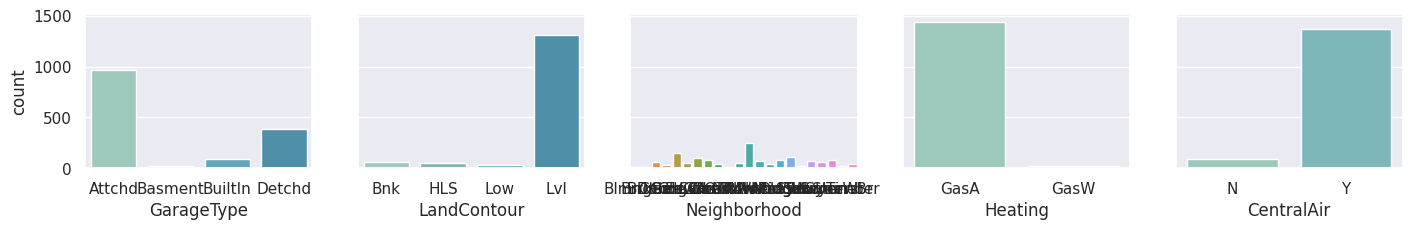

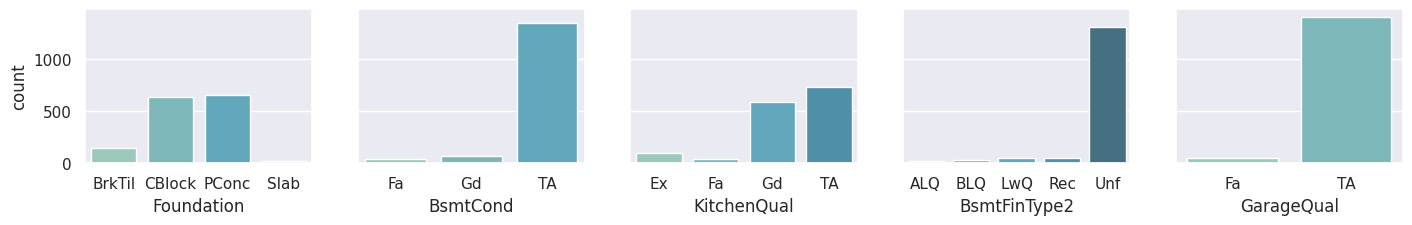

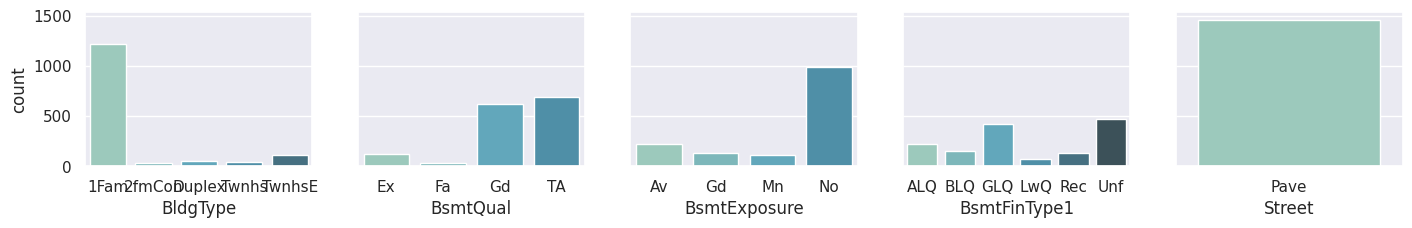

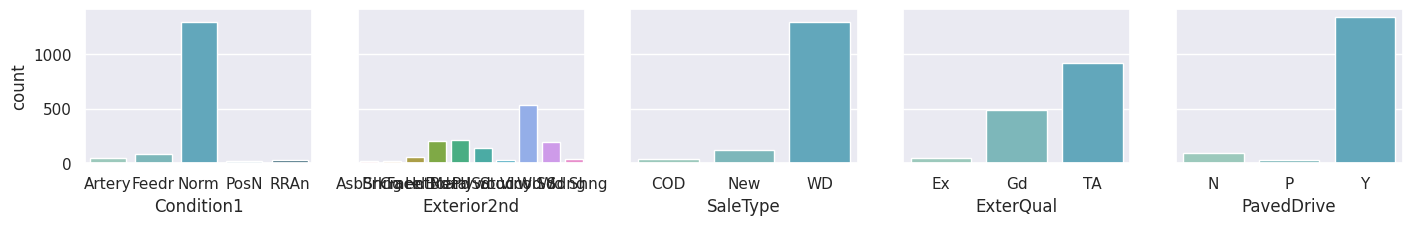

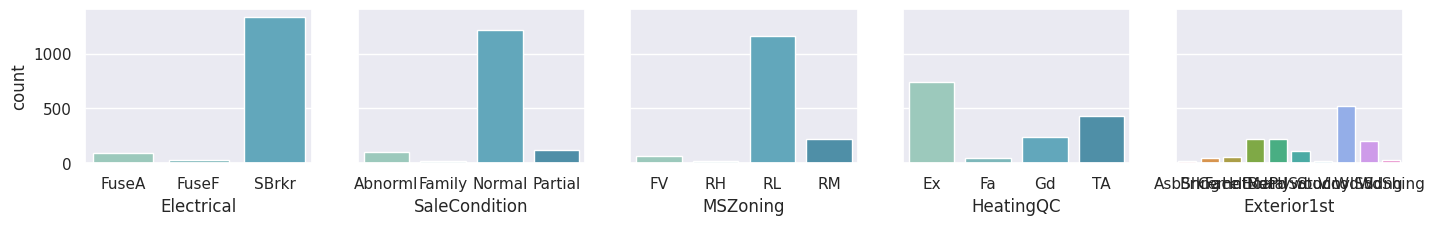

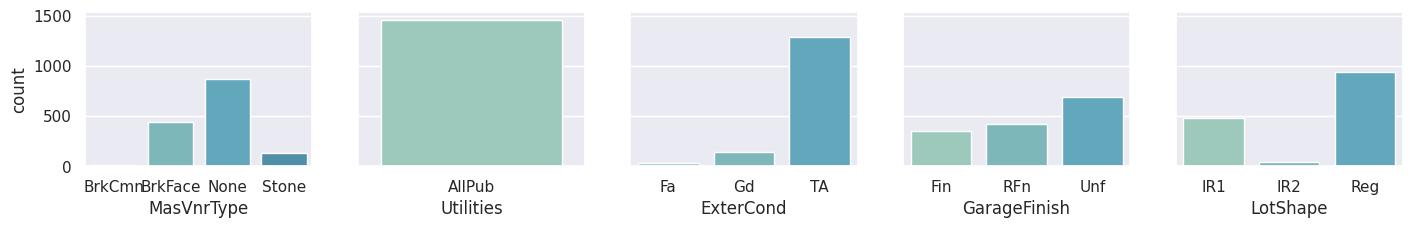

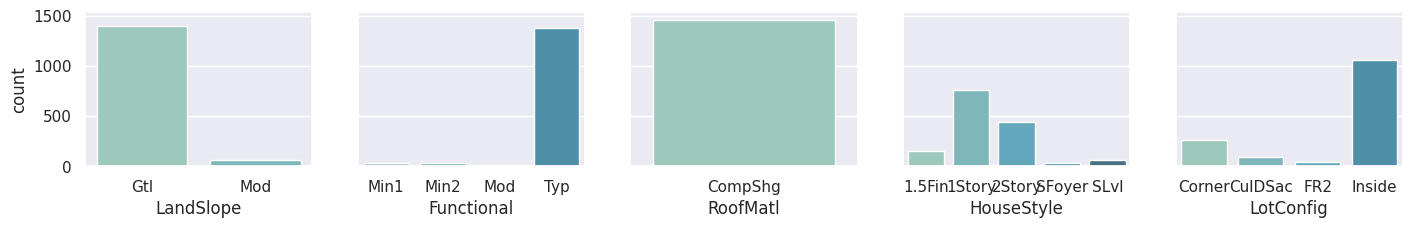

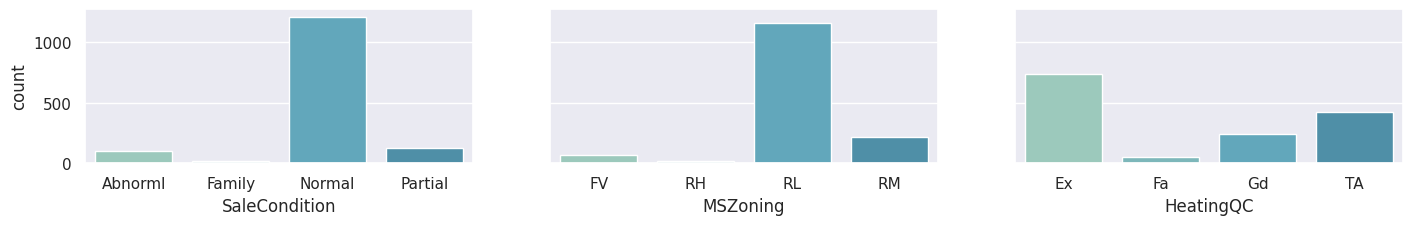

In [11]:
ds_boost.show_categorical(df, sharey=True)

#### Target vs Categorical features

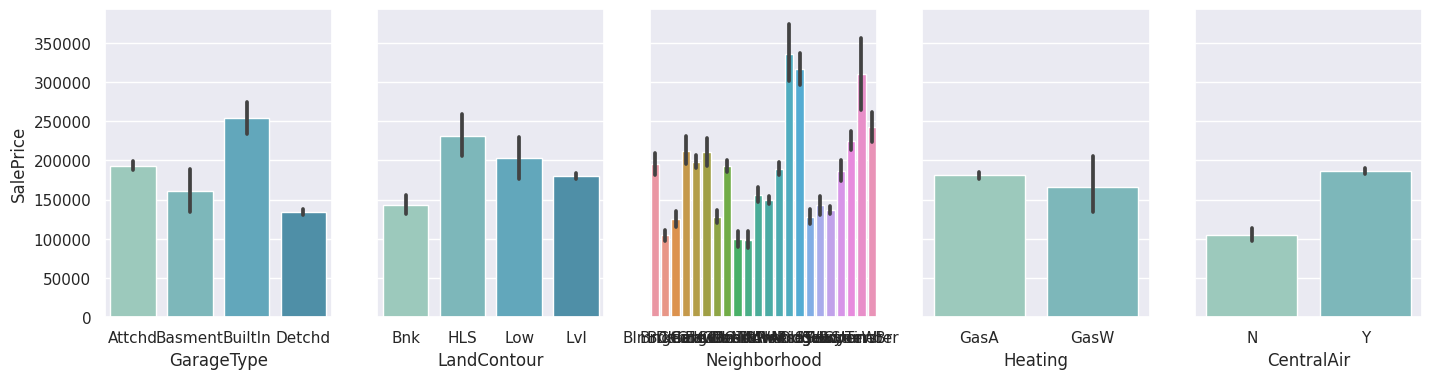

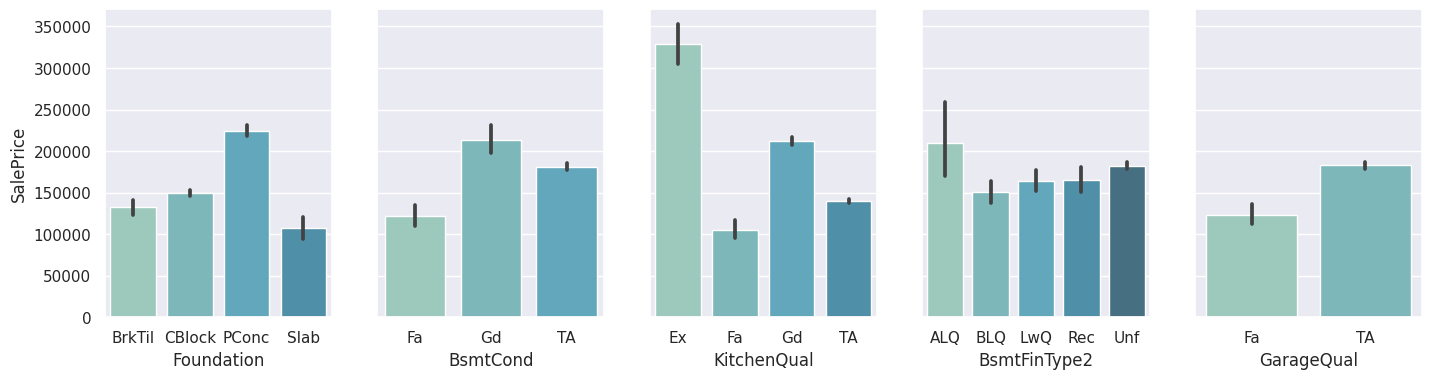

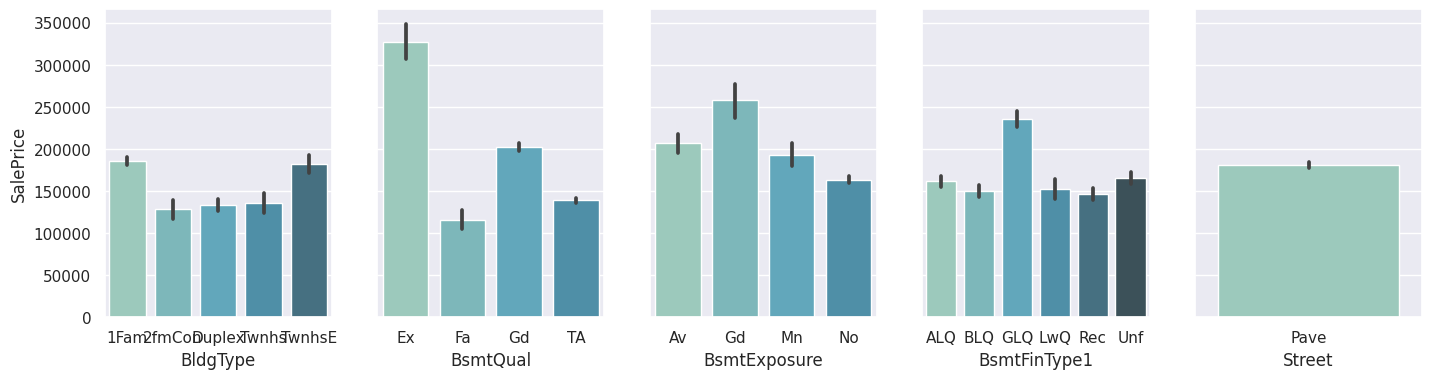

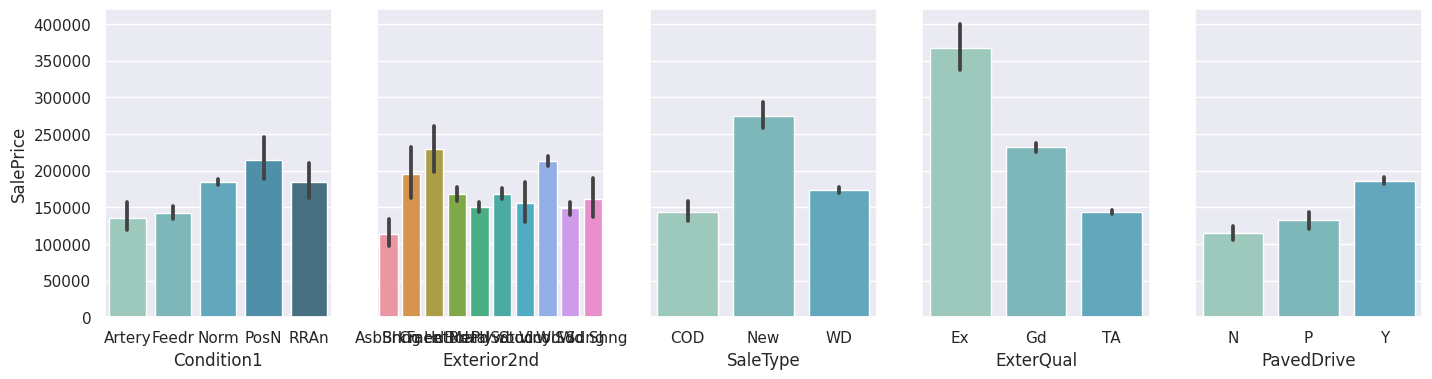

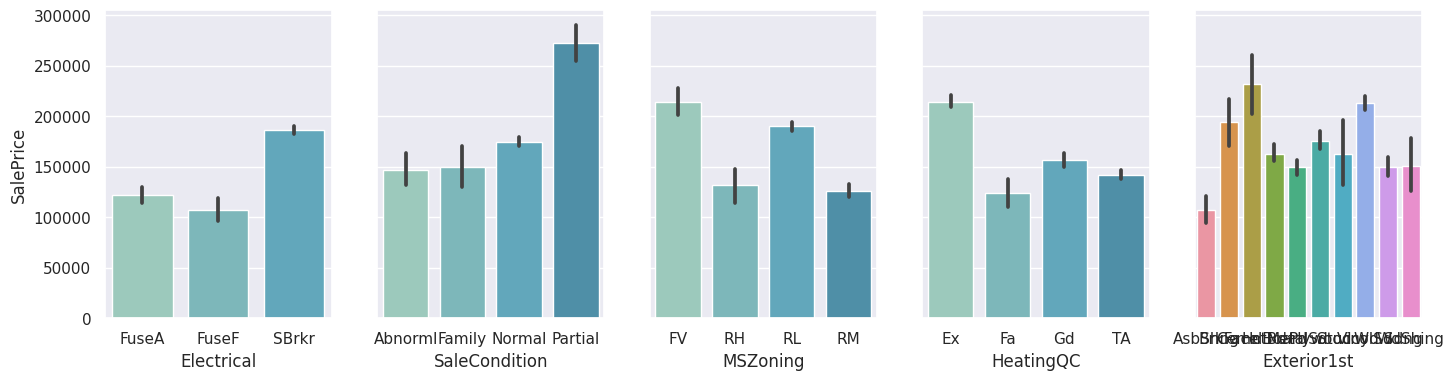

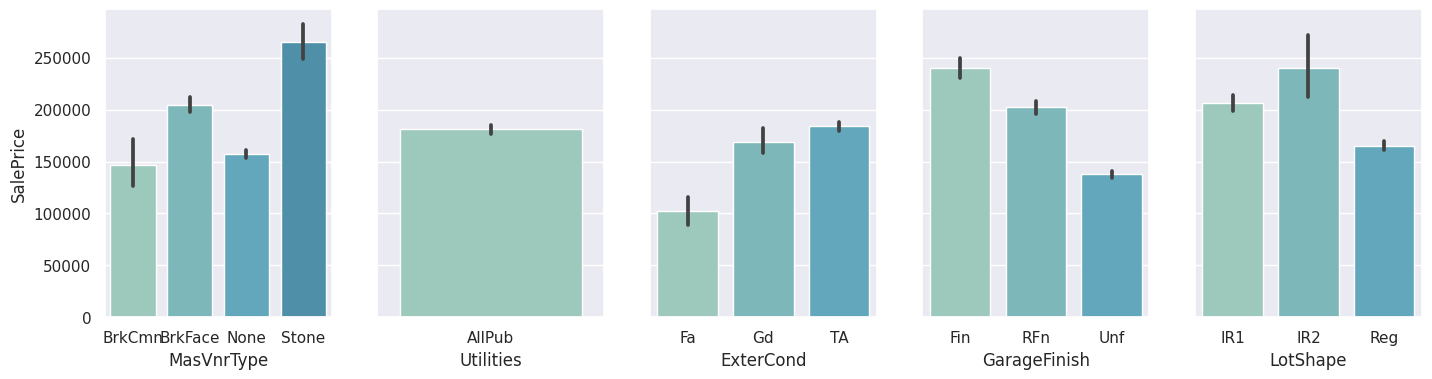

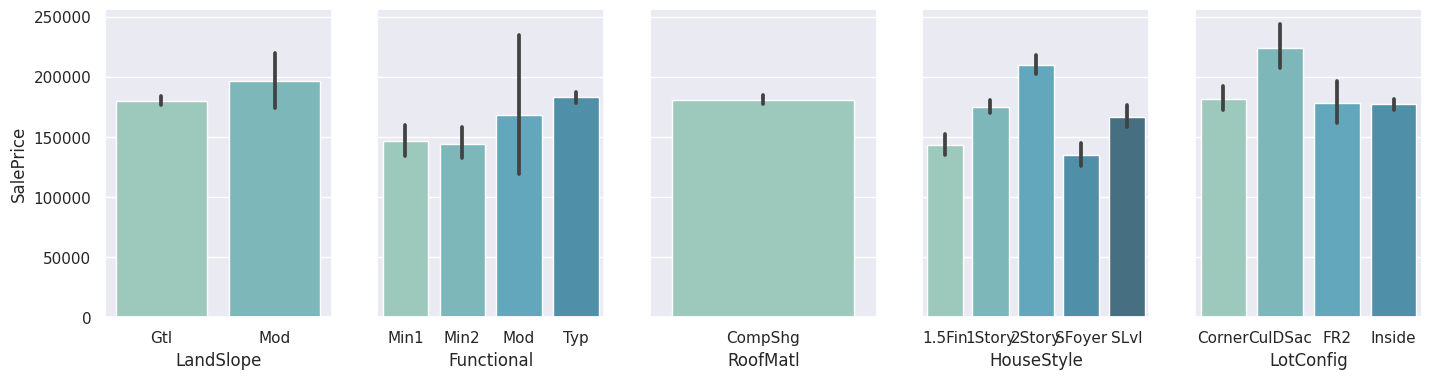

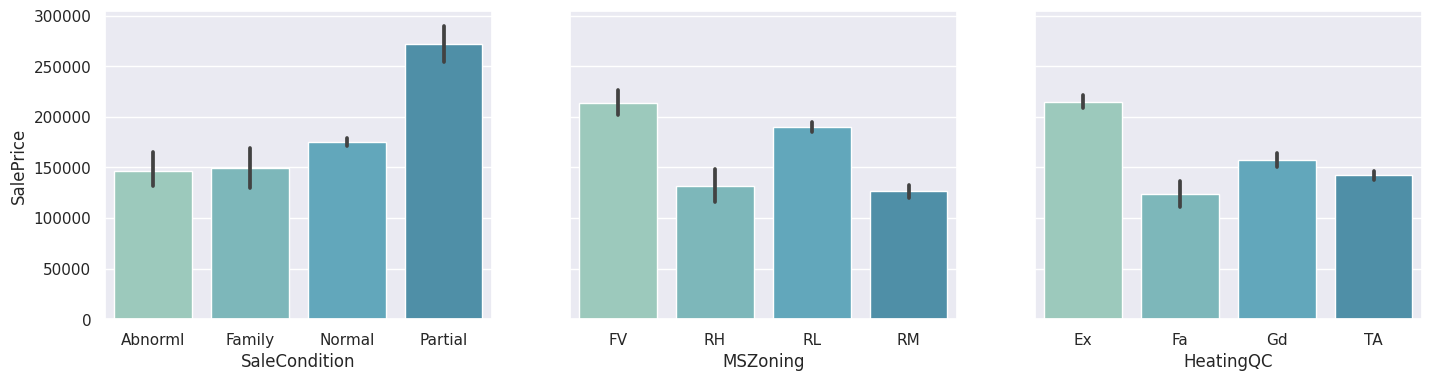

In [12]:
ds_boost.show_target_vs_categorical(df, target)

#### Numerical features

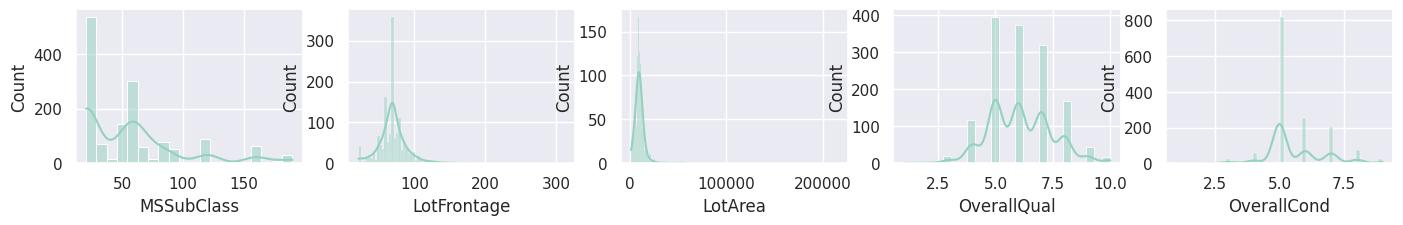

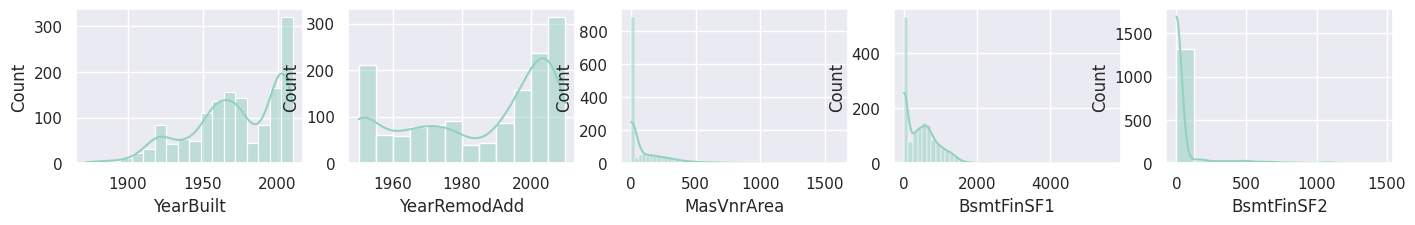

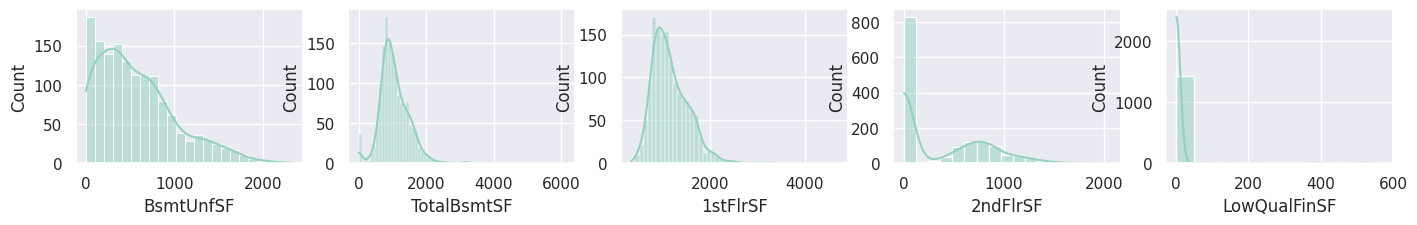

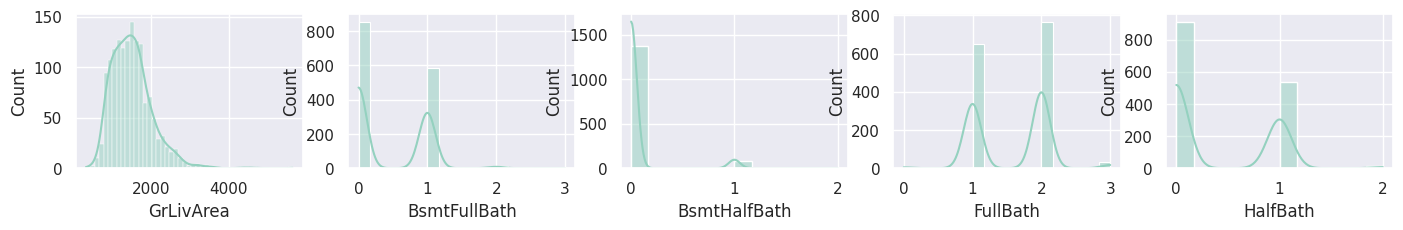

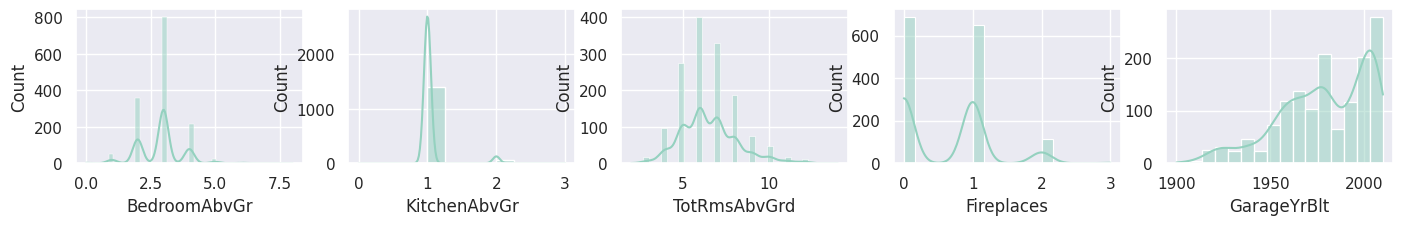

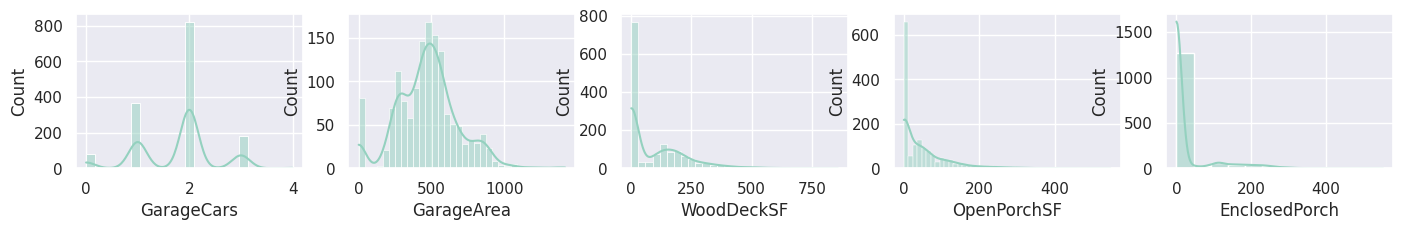

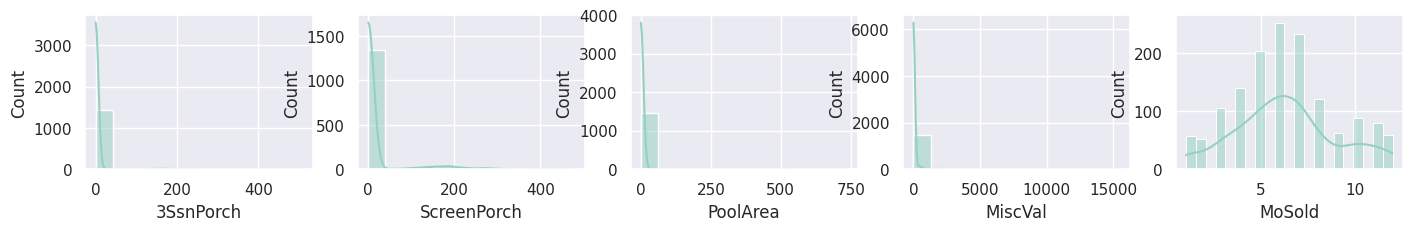

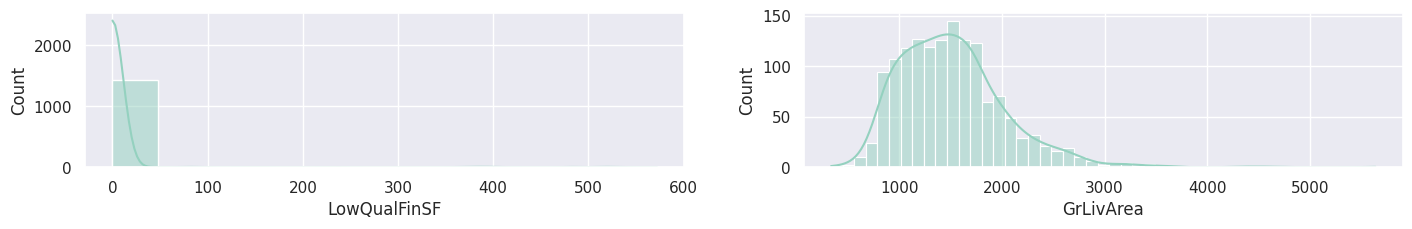

In [13]:
ds_boost.show_numerical(df, kde=True)

#### Target vs Numerical features

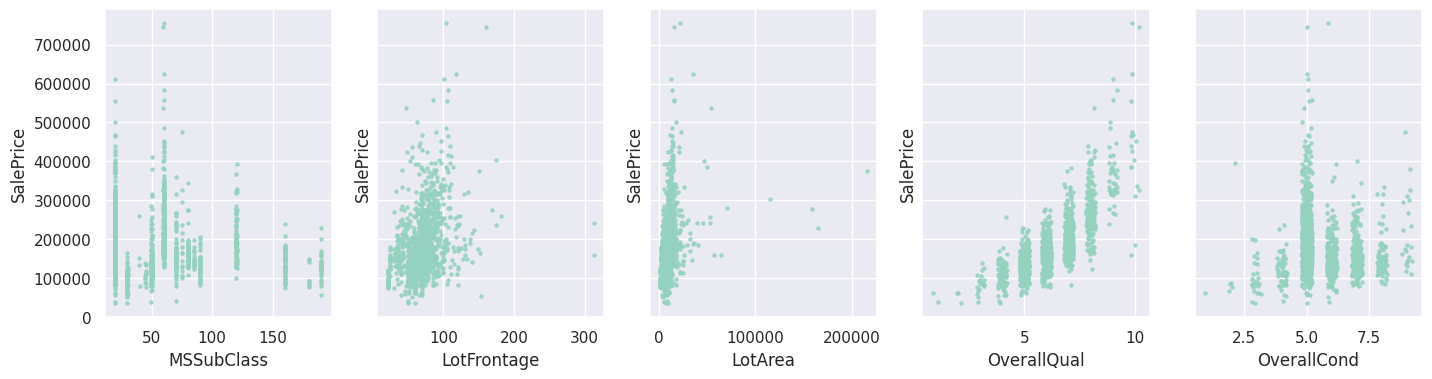

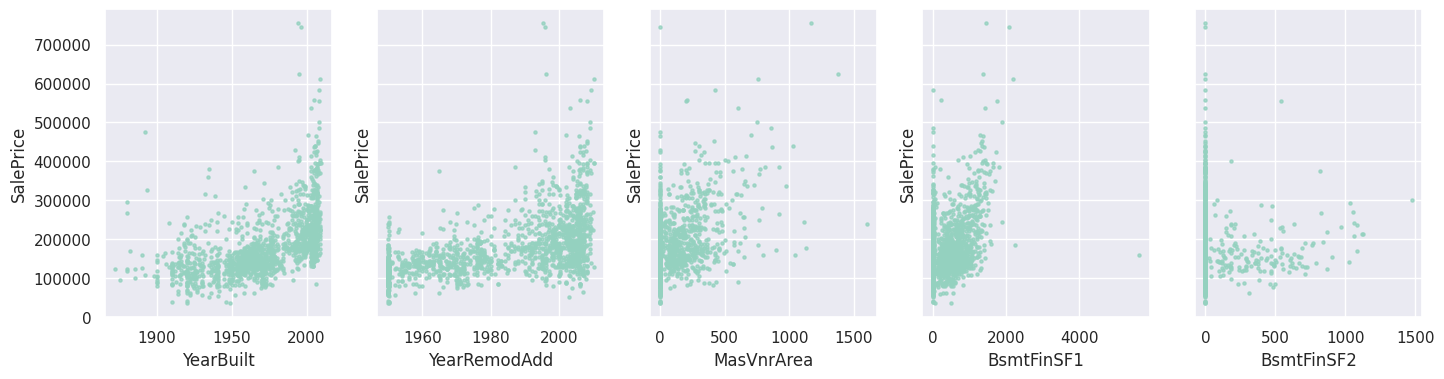

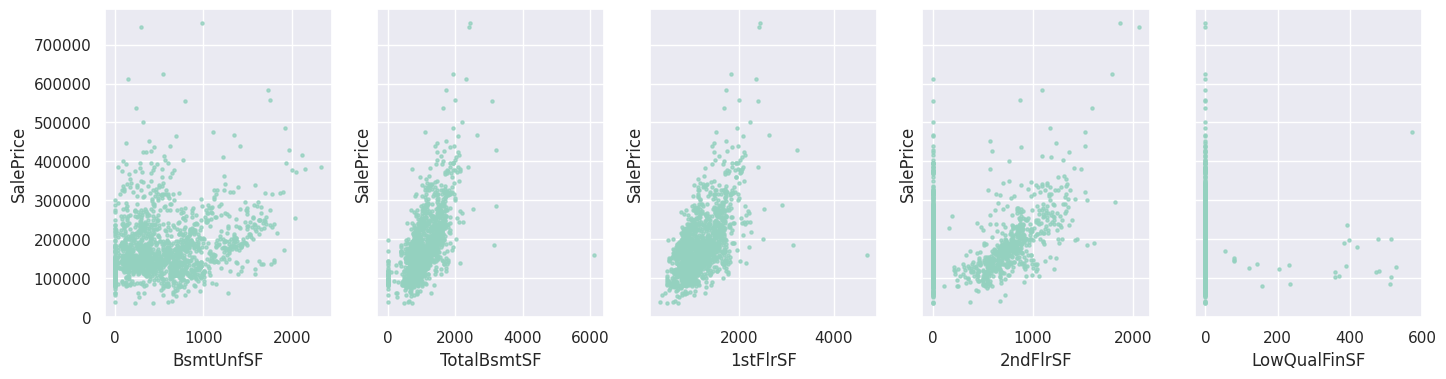

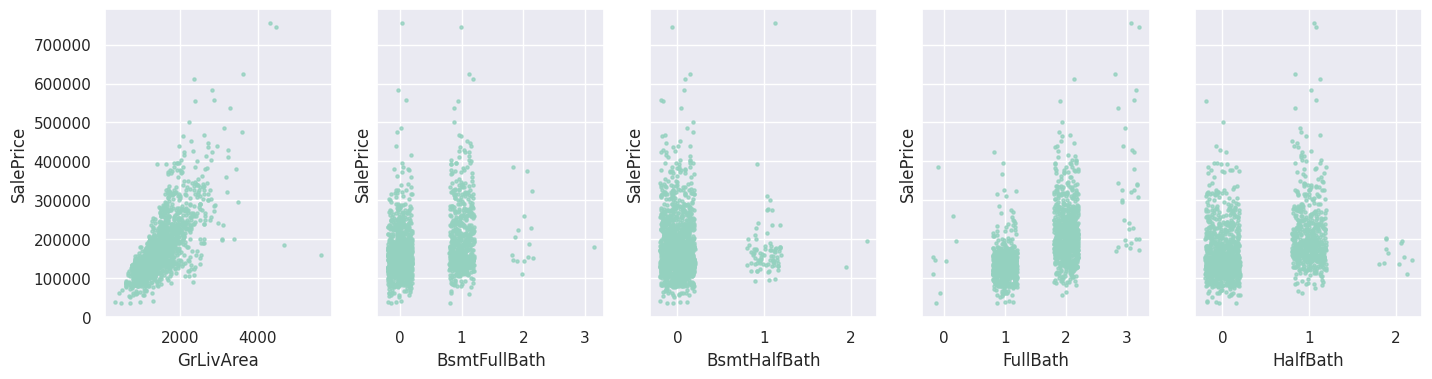

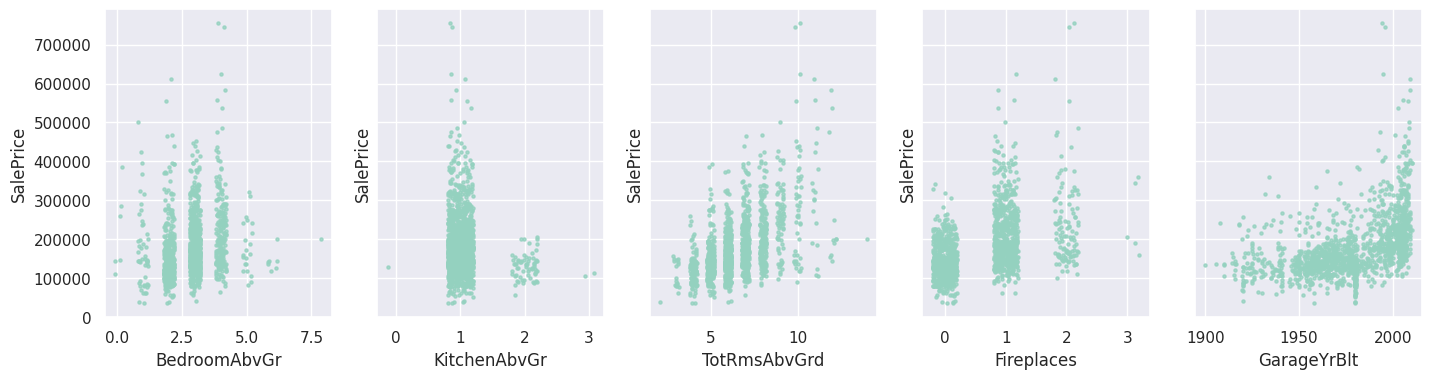

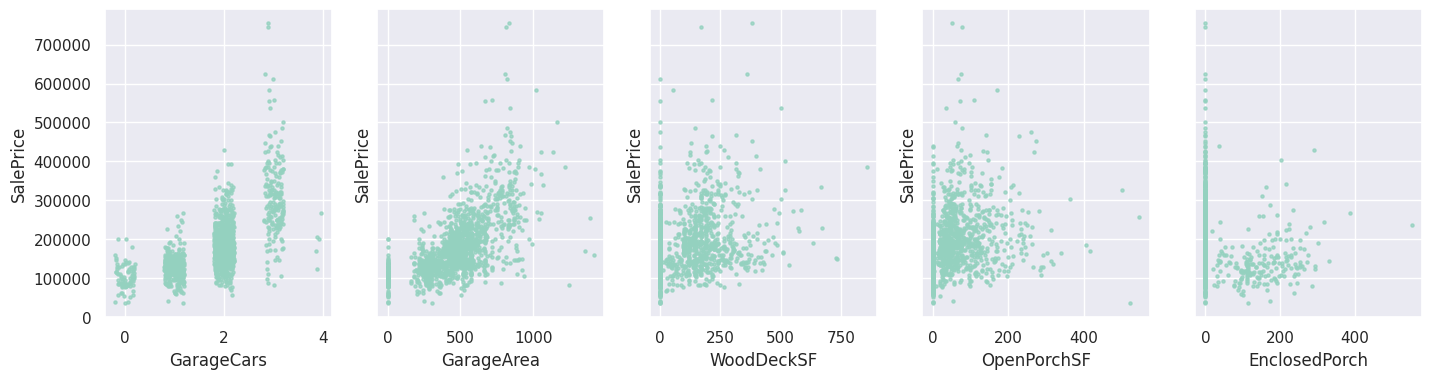

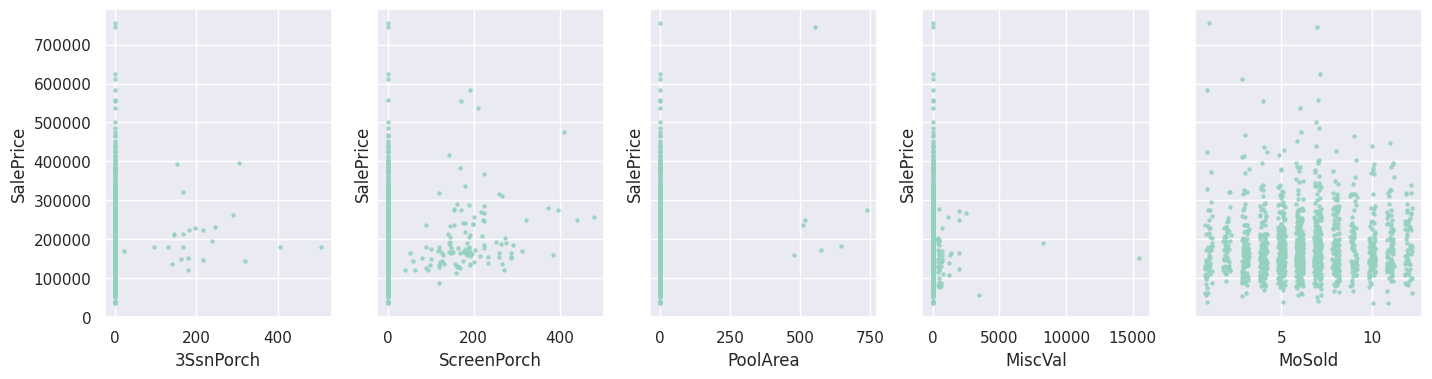

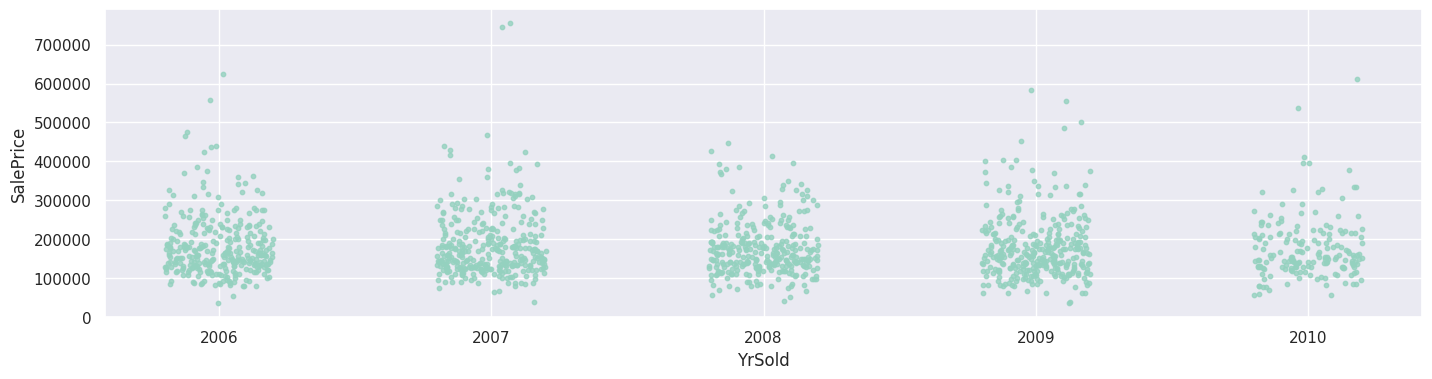

In [14]:
ds_boost.show_target_vs_numerical(df, target, point_size=20, jitter=0.2, fit_reg=False)

#### Correlation between numerical features and target

/home/angel/DRIVE/0_repos/data-science-keras/src/ds_boost/ds_boost.py:778: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = copy_df.corr().loc[numerical_f, target].fillna(0).sort_values(target, ascending=False).round(2)


[]

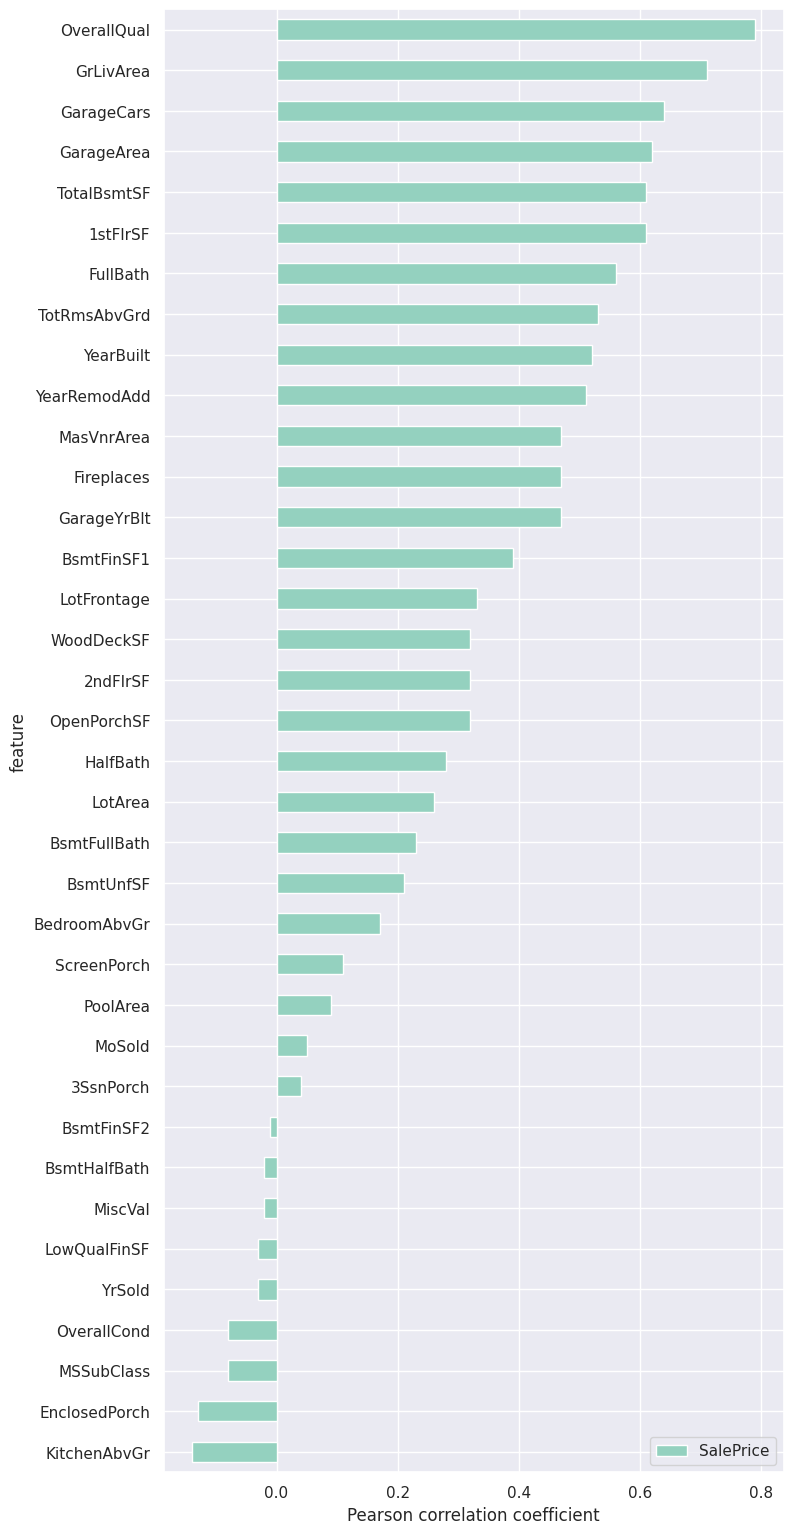

In [15]:
ds_boost.correlation(df, target)

## 2. Neural Network model

### Select the features

In [16]:
droplist = []  # features to drop

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(droplist, axis="columns", inplace=True)
data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,LotShape,LandSlope,Functional,RoofMatl,HouseStyle,LotConfig,RoofStyle,GarageCond,Condition2,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,Reg,Gtl,Typ,CompShg,2Story,Inside,Gable,TA,Norm,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,Reg,Gtl,Typ,CompShg,1Story,FR2,Gable,TA,Norm,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,IR1,Gtl,Typ,CompShg,2Story,Inside,Gable,TA,Norm,223500.0


### Scale numerical variables
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [17]:
data, scale_param = ds_boost.scale(data)

### Create dummy features
Replace categorical features (no target) with dummy features

In [18]:
data, dict_dummies = ds_boost.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target]  # sorted neural network inputs

data.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,HouseStyle_SLvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,RoofStyle_Gable,RoofStyle_Hip,GarageCond_Fa,GarageCond_TA,Condition2_Norm
0,0.073350,-0.220800,-0.207071,0.651256,-0.517023,1.050633,0.878369,0.513928,0.575228,-0.288554,...,0,0,0,0,1,1,0,0,1,1
1,-0.872264,0.460162,-0.091855,-0.071812,2.178881,0.156680,-0.429428,-0.570555,1.171591,-0.288554,...,0,0,0,1,0,1,0,0,1,1
2,0.073350,-0.084607,0.073455,0.651256,-0.517023,0.984414,0.829932,0.325803,0.092875,-0.288554,...,0,0,0,0,1,1,0,0,1,1


### Split the data into training, validation, and test sets
Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

In [19]:
test_size = 0.2
val_size = 0.1
random_state = 9

x_train, y_train, x_val, y_val, x_test, y_test = ds_boost.data_split_for_ml_with_val(
    data, target, test_size=test_size, val_size=val_size, random_state=random_state
)

23:03:50 - DEBUG 	 train size 	 X:(1051, 192) 	 Y:(1051, 1)
23:03:50 - DEBUG 	 validation size	 X:(117, 192) 	 Y:(117, 1)
23:03:50 - DEBUG 	 test size  	 X:(292, 192) 	 Y:(292, 1) 


One-hot encode the output not needed for regression

### Build and Train the Neural Network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                18528     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 18,625
Trainable params: 18,625
Non-trainable params: 0
_________________________________________________________________
23:03:50 - DEBUG 	 Training ....


/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
DEBUG:DS_logger.ds_boost.ds_boost:Training ....


23:03:53 - DEBUG 	 time: 	 2.6 s


DEBUG:DS_logger.ds_boost.ds_boost:time: 	 2.6 s


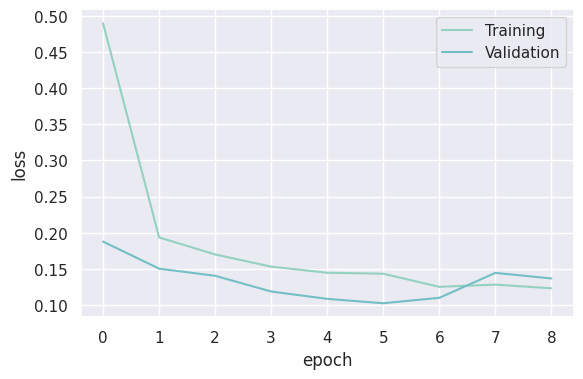

23:03:53 - DEBUG 	 Training loss:  	0.1232


DEBUG:DS_logger.ds_boost.ds_boost:Training loss:  	0.1232


23:03:53 - DEBUG 	 Validation loss: 	 0.1368


DEBUG:DS_logger.ds_boost.ds_boost:Validation loss: 	 0.1368


23:03:53 - DEBUG 	 Model saved at models/house_prices.h5


DEBUG:DS_logger.ds_boost.ds_boost:Model saved at models/house_prices.h5


4/4 [==============================] - 0s 2ms/step
Training   R2-score: 	0.897
Validation R2-score: 	0.888


In [20]:
model_path = os.path.join("models", "house_prices.h5")

weights = weights = keras.initializers.TruncatedNormal(stddev=0.0001)
opt = keras.optimizers.Adam(lr=0.00005)

model = None
model = ds_boost.build_nn_reg(
    x_train.shape[1],
    y_train.shape[1],
    hidden_layers=1,
    input_nodes=x_train.shape[1] // 2,
    dropout=0.2,
    kernel_initializer=weights,
    bias_initializer=weights,
    optimizer=opt,
    summary=True,
)

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=0)]

ds_boost.train_nn(
    model,
    x_train,
    y_train,
    validation_data=[x_val, y_val],
    path=model_path,
    epochs=500,
    batch_size=16,
    callbacks=callbacks,
)

from sklearn.metrics import r2_score

ypred_train = model.predict(x_train)
ypred_val = model.predict(x_val)
print("Training   R2-score: \t{:.3f}".format(r2_score(y_train, ypred_train)))
print("Validation R2-score: \t{:.3f}".format(r2_score(y_val, ypred_val)))

### Train with Cross Validation

In [21]:
# restore training set
x_train = np.vstack((x_train, x_val))
y_train = np.vstack((y_train, y_val))

In [22]:
from sklearn.model_selection import KFold


def cv_train_nn(x_train, y_train, n_splits):
    """Create and Train models for cross validation. Return best model"""

    skf = KFold(n_splits=n_splits, shuffle=True)

    score = []

    best_model = None
    best_loss = float("inf")

    print(f"Training {n_splits} models for Cross Validation ...")

    for train, val in skf.split(x_train[:, 0], y_train[:, 0]):
        model = None
        model = ds_boost.build_nn_reg(
            x_train.shape[1],
            y_train.shape[1],
            hidden_layers=1,
            input_nodes=x_train.shape[1] // 2,
            dropout=0.2,
            kernel_initializer=weights,
            bias_initializer=weights,
            optimizer=opt,
            summary=False,
        )

        history = ds_boost.train_nn(
            model,
            x_train[train],
            y_train[train],
            show=False,
            validation_data=(x_train[val], y_train[val]),
            epochs=500,
            batch_size=16,
            callbacks=callbacks,
        )

        val_loss = history.history["val_loss"][-1]

        score.append(val_loss)

        if val_loss < best_loss:  # save best model (fold) for evaluation and predictions
            best_model = model
            best_loss = val_loss

    print("\nCross Validation loss: {:.3f}".format(np.mean(score)))
    return best_model


model = cv_train_nn(x_train, y_train, 10)

Training 10 models for Cross Validation ...


/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


KeyError: in user code:

    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1213, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/home/angel/miniconda3/envs/ds-keras/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 216, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense_2/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'


### Evaluate the model

In [ ]:
y_pred_test = model.predict(x_test, verbose=0)
ds_boost.regression_scores(y_test, y_pred_test, return_dataframe=True, index="DNN")

,Loss,R2 Score
DNN,0.15,0.86


### Make predictions

SalePrice . Prediction error:
Mean: 	 -0.93%
Stddev:  10.70%


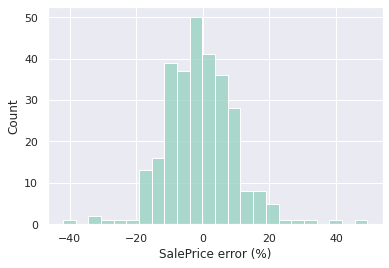

In [ ]:
def predict_nn(model, x_test, target):
    """Return a dataframe with actual and predicted targets in original scale"""

    for t in target:
        pred = model.predict(x_test, verbose=0)
        restore_pred = pred * scale_param[t][1] + scale_param[t][0]
        restore_pred = restore_pred.round()

        restore_y = y_test * scale_param[t][1] + scale_param[t][0]
        restore_y = restore_y.round()

        pred_label = f"Predicted_{t}"
        error_label = f"{t} error (%)"

        pred_df = pd.DataFrame({t: np.squeeze(restore_y), pred_label: np.squeeze(restore_pred)})

        pred_df[error_label] = ((pred_df[pred_label] - pred_df[t]) * 100 / pred_df[t]).round(1)

        print(t, ". Prediction error:")
        print("Mean: \t {:.2f}%".format(pred_df[error_label].mean()))
        print("Stddev:  {:.2f}%".format(pred_df[error_label].std()))
        sns.histplot(pred_df[error_label])

    return pred_df


pred_df = predict_nn(model, x_test, target)

In [ ]:
pred_df.head(10)

,SalePrice,Predicted_SalePrice,SalePrice error (%)
0,151400.0,210323.0,38.900002
1,241500.0,207148.0,-14.200000
2,82000.0,76309.0,-6.900000
3,162000.0,168068.0,3.700000
4,140000.0,146666.0,4.800000
5,227000.0,210341.0,-7.300000
6,228950.0,279368.0,22.000000
7,208300.0,189275.0,-9.100000
8,128500.0,119665.0,-6.900000
9,165000.0,167816.0,1.700000


The error of the predicted sale prices can be modeled by a normal distribution, almost zero centered, and with a standard deviation of < 12%. Thus, ~95% of the houses are predicted within a price error < 24% respect to the actual one. 

Note: there is data leakage when removing low-frequency categorical values and scaling numerical features


### Compare with classical ML

In [ ]:
ds_boost.ml_regression(x_train, y_train, x_test, y_test)

Linear
KNeighbors
Random Forest
LGBM


,Time (s),Test loss,Test R2 score
LGBM,4.7,0.13,0.88
Random Forest,0.3,0.14,0.87
Linear,1.4,0.14,0.87
KNeighbors,0.0,0.29,0.74


####  Best tree-based model

In [ ]:
from lightgbm import LGBMRegressor

random_forest = LGBMRegressor(n_jobs=-1, n_estimators=50, max_depth=17, random_state=9).fit(x_train, np.ravel(y_train))

y_pred = random_forest.predict(x_test)

ds_boost.regression_scores(y_test, y_pred, return_dataframe=True, index="LGBM")

,Loss,R2 Score
LGBM,0.13,0.88


#### Feature importance

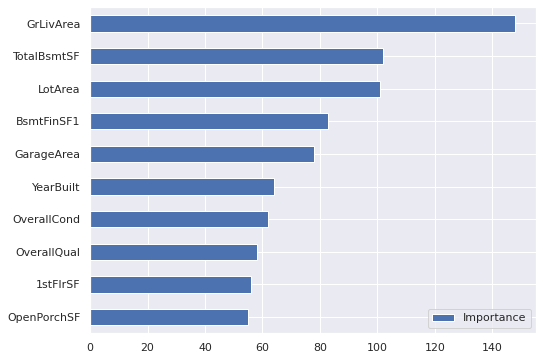

In [ ]:
results = ds_boost.feature_importance(model_features, random_forest)